In [208]:
import string
import random
import time
import math

import torch.nn as nn
import shapefile
from tqdm import tqdm_notebook as tqdm
import sklearn.feature_extraction
import numpy
import torch
import torch.random
import matplotlib.pyplot as plt

In [200]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, inp, hidden):
        batch_size = inp.size(0)
        encoded = self.encoder(inp)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, inp, hidden):
        encoded = self.encoder(inp.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.autograd.Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                torch.autograd.Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))

In [10]:
suburb_shape = shapefile.Reader('../NSW_LOCALITY_POLYGON_shp/NSW_LOCALITY_POLYGON_shp')

In [14]:
names = [r.NSW_LOCA_2 for r in suburb_shape.records()]

In [100]:
letters = sorted(string.ascii_uppercase + "'- *")

In [270]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = letters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def random_training_set(corpus, chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, len(corpus) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = corpus[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = torch.autograd.Variable(inp)
    target = torch.autograd.Variable(target)
    return inp, target

def train(inp, target, batch_size, chunk_len, decoder, optimiser):
    hidden = decoder.init_hidden(batch_size)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    optimiser.step()

    return loss.data[0] / chunk_len

In [271]:
def generate(decoder, prime_str='****', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden(1)
    prime_input = torch.autograd.Variable(char_tensor(prime_str).unsqueeze(0))

    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = letters[top_i]
        predicted += predicted_char
        inp = torch.autograd.Variable(char_tensor(predicted_char).unsqueeze(0))

    return predicted

In [272]:
# inputs = []
# outputs = []
# window_size = 4
# for name in tqdm(names):
#     name = '*' * window_size + name + '****'
#     for i in range(len(name) - window_size):
#         inputs.append(name[i:i + window_size])
#         outputs.append(name[i + window_size])

In [273]:
input_corpus = ''.join('*' * 4 + n for n in names) + '****'

In [274]:
# letter_to_int = {l:i for i, l in enumerate(letters)}

In [275]:
# input_arr = numpy.zeros((len(inputs), 4, len(letters)))
# for n, inp in enumerate(inputs):
#     for i, l in enumerate(inp):
#         input_arr[n, i, letter_to_int[l]] = 1

In [276]:
# output_arr = numpy.zeros((len(inputs), len(letters)))
# for n, out in enumerate(outputs):
#     output_arr[n, letter_to_int[l]] = 1

In [307]:
decoder = RNN(
    len(letters),
    16,
    len(letters),
    n_layers=3,
)

In [315]:
decoder_optimiser = torch.optim.Adam(decoder.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [309]:
all_losses = []

In [ ]:
start = time.time()
loss_avg = 0
n_epochs = 100000
batch_size = 128
chunk_len = 4
for epoch in tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set(input_corpus, chunk_len, batch_size), batch_size, chunk_len,
                 decoder, decoder_optimiser)
    loss_avg += loss
    all_losses.append(loss.item())

    if epoch % 100 == 1:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(decoder, '****', 100), '\n')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 0s (1 0%) 1.7293]
****DOLANORDS******PRENMOUNT PARK*****LODSTER********DALLE*******CASTSS EABBA GULGARA*******ANCHILL***** 

 2s (101 0%) 1.9510]
****PARRAH******DURICOTTLE WATU********ELANGAGE BAY******BANGA*********JOWSON*******DARRA********SCHERIN 

 5s (201 0%) 1.7067]
****FORINGBERRAL******LEALLE*******LIRRM*******KAWOWA*******MILE*******DIMANERS*******KIMBALLEIGHT****** 

 8s (301 0%) 1.7880]
****WHER WOOLOOG******FOWERA*******DARA*******ELSTON*******KARRY*****LUDANGELLAH******KELL******RAYALL** 

 11s (401 0%) 1.7401]
****WOLLIS CREEK******QARK*****KIN HILLL******BROOK******DARRAH*******TREACH******CALLVEINE********LADAL 

 13s (501 0%) 1.7821]
****VILBA*******DILL******LOUNTBROOK******CARSOWRY SOUTTAMOO******STONAL CREEK*****KULBA*******ALAXS MOU 

 16s (601 0%) 1.7822]
****STOWOMOON*******KRIANDHI******DENINGALGADEN********DOMBUDLAGEBRO SND*******LINDS FLAT*******ALICAROO 

 19s (701 0%) 1.8717]
****COLD******LARA*******GATHONE*******GEF********LEEE********MATHENDES CREEK****

 7s (6201 6%) 1.8231]
****FURINT***********DARRIVER********DAREA*******FREEDINES*******KELENER*******LUKERY BAY*******DARRAH** 

 10s (6301 6%) 1.8130]
****BRURRAH*******SHY PLAERNHEIGHTS*******ATH*******LILLORS******KMERA********LOSTAN*********LANINDINGLE 

 12s (6401 6%) 1.7773]
****COLUIS*******RAGOOTANINGO******DANTENELLIMITZURRY*****LANAH******GUDDEN********LASHOLTTANELL******BU 

 16s (6501 6%) 1.7728]
****BUFHEAD*********GANKEST********MYLSTOWN*******LITS POINT***********FARRA*******ST POINT*********MAYL 

 19s (6601 6%) 1.7873]
****TOROTTE WEST*********KRIGAMS VALLENE CREEK*****GOOKLEYS HOLLSS CREEK******GLER CREEK****HANNEN****** 

 22s (6701 6%) 1.7913]
****REDIROO*****WAT******FYRINGURORS*****CRAIN********LILMORRIVER********MANSIGHTS*******KIMOLOWES STATO 

 26s (6801 6%) 1.8862]
****MATHOREENDALE*******ARRA*******MATH ISLE BRITH COWTH RIDGE********KALBRA*******EANDINGAN PARK*****LA 

 29s (6901 6%) 1.8159]
****TOVE*******EASCHEM FLATE*******DAMP********MACKS PARK*****GROY B

 57s (12401 12%) 1.7431]
****THE GAKE CREEK******DALLERESBURRIVER********BAPPER TORNGS WALLINS******KRA*******LAGOOLAROORANDFIELL 

 59s (12501 12%) 1.7739]
****WAL******WEDIE CURLDA*********OUROFT********DANER CORMERRING********DATH********DATH*******HAMONG*** 

 2s (12601 12%) 1.7327]
****FURNE*******LITS HEIGHT*******ADALLWANGANBERRA*******GUNTA VALEY*******DAWANGAL*******ATSHRANCETLE W 

 4s (12701 12%) 1.6266]
****KELER BEACK GUDDALE********CABRA********DOAKHY******KUNIE CURENINGTON******DANRAH******BARRINGTON*** 

 7s (12801 12%) 1.9067]
****WAHROWA******BUULAIL*****DORMALLE******DENCOVE********LIMANBUL******MRING********LATRAWANS VALEYOMLE 

 13s (12901 12%) 1.8181]
****STARE*******LITON******MOLUE POTS CREEK******LALLE******LILBUNDELLS*******LAPPE MARRAH******DAMBARA* 

 18s (13001 13%) 1.7748]
****RAHILL******LANK*****LYTES HEINGALGA***********ARINATAI******LUCHTS*******LYTE CREEK******ALELANG*** 

 23s (13101 13%) 1.6590]
****HURLTE CREEK******LELEN******LUNINGMALLONG*******K

 48s (18501 18%) 1.7002]
****WINABBA*********OUROD HEADO CREEK******LLITE*********UALLITANIEINEIGHTS********ALLE******ANORINGHIN* 

 51s (18601 18%) 1.8923]
****UPPLER HILLS*******ADEE*******LAWYDIND*********DUMOREES WALL PLAIN******MATH********KATREEN PARK**** 

 53s (18701 18%) 1.7628]
****MULMEAN**********MARRA******DANRIA SOOUTHREAM********LOBLAND*********DAKER*******JEAKHALE********LAT 

 56s (18801 18%) 1.8748]
****CATH RICHIGOSIGONMY FLAPA*********BROOK******LAKORIFER BAY*********BARRAWARRA******GOOGALL*******DAR 

 58s (18901 18%) 1.7874]
****ROND*********BULLATYA*******BROOK******DARROWER*******NARM******MRA POINT**********ELE*******LITINE  

 1s (19001 19%) 1.6597]
****BUTTANALGROSS******LYRA CRAST********GHEIGHTS PENDURIMBO*****DAND*********LONT BAY********GLIGHTS*** 

 4s (19101 19%) 1.8295]
****THS NOUTH********DARRRA*******BULLA HILLL******VANILL******SAPATH********KEACH*****ELE******DAMBLA** 

 6s (19201 19%) 1.8522]
****BONES*******DALE*******KOUTH*******LITERSTYY******

 34s (24601 24%) 1.8007]
****CHALE*******LANREEK******EADYRS WITHEN********FURINGRA*********MELBLINDLEA BEACHELL*******LITESINGLE 

 37s (24701 24%) 1.6967]
****DENTAINS CREEFAR********MOUPURUNDI*******DARRI*****VERY*********MARRRY CREEK*******LAGOAGES OOGAGOOL 

 40s (24801 24%) 1.7579]
****HAMPE**********LILLD NELL CROVER*******LAKIONALDERBY*******MANGLE********MRATILEY********DATH******* 

 42s (24901 24%) 1.6316]
****WOOD*******DARLINGSSADLE PLATALE**********DELS BEACHST VALE*********FYA**********BARRICGE CREEK***** 

 45s (25001 25%) 1.7882]
****REACH*****STRASINDY********A**EALLDVILLE OSE*******GRIGATELAH*******LAMBANS*********FARRA******YUMBI 

 48s (25101 25%) 1.6830]
****JUNON******DAROOGER FUAREE*********FARY*******FOREST MACKY VALE*********ALE*******DARRA******YANDING 

 51s (25201 25%) 1.8368]
****CHILL******LAWRABEACHWONG*********REACH*****DELENGAN***********DREADRA********LOSTARRIE********LACHH 

 54s (25301 25%) 1.7988]
****TUNGMAN**********GRICK******LAKREMANBURY GEATT 

 25s (30701 30%) 1.7808]
****BATEN*******FARRA******LUTON******GURRANDLESGAROO GULLOONALLIN*****KELE FLAD********DELDDLEIGHTWANTA 

 28s (30801 30%) 1.7602]
****CABARS******MAMAN BEACHELBY******YALVENDALE*********LOND********LAMBARTON******KHEAPPAL******MURINWO 

 31s (30901 30%) 1.7991]
****FALINANGALLEDOVE********EALLIA******USHTS*********CHARRA******WELARENEY HILLE*******LILL*******LAKYR 

 34s (31001 31%) 1.7028]
****MINT NORTON******KROT*********ELAT******LANRIAMONG*********LUNIFER CREEK*******FOREST ISLON******DEX 

 36s (31101 31%) 1.7472]
****MULLINDENFERN*******LILE********CONG*********LEALBA**********BUMBORIMBRI*****UPPLAINT CPERT HEREST C 

 39s (31201 31%) 1.6681]
****WEST*****THE IVER ROCKE CREEK******DEMEMAH*******LELFORD********GAKOOTION******MRAH*******FURINNA*** 

 41s (31301 31%) 1.7870]
****REDDEYS BAY********LUTONG*********EABELGORALLABBA*********OLDS HEUVABLE*******DARRABAINE*******LAWAH 

 44s (31401 31%) 1.7744]
****QUAROO******LUNICK CREEK******LAKORANBELGAL****

 18s (36801 36%) 1.7302]
****GUTRANGA POINT BEACH*****LATH********DARM*****DAKERTIN*******HALLI PARK*****FINNI******BRINGBENY**** 

 20s (36901 36%) 1.7680]
****JEABER********HEK******DILLIANS FLAT******DELBERRANGLE*********LEAKE*********LUTON******DAKBUNNIE*** 

 23s (37001 37%) 1.7558]
****YANDS*********ELETHE PILLEN******DALEY VALLENES CREEK*******FARTH HILLVERS CREEK*******ADALSI*****KR 

 26s (37101 37%) 1.7592]
****BULAH*******DAMELGROVE*********LITOMBANTAIN********LIRRA******GEE VALEY*********DANKERS******FALMALL 

 28s (37201 37%) 1.7538]
****SYULMANS CREEK******QILEN******CLIT********COTTOWN*******KIS******ELESTONERBATHARBOODKELLONGERTON*** 

 32s (37301 37%) 1.6590]
****WANTAIN POINT********ALALTON PARK*****LAKLESGOOGAGHTS*******CROOKS MILLI****WOI HILLVI*******SSH HEU 

 35s (37401 37%) 1.6920]
****SRAYKS********KILD********ALELD GARNERRONG********GLERS GEANDS***********DRAYVILLE*******DALONG***** 

 38s (37501 37%) 1.9284]
****HERRIGHTH*********CRA PARK*****ERUNNENS HILLLBR

 15s (42901 42%) 1.6910]
****CARL MASS*******KARRAMERAMILSON CREEK*******KARL******KUCH*****LATHONS GROSGI******UMOUGARA********H 

 17s (43001 43%) 1.8222]
****BROCKROUGH*****KELFAT*******LACKANIA*******DIEY HILLLANDKINIA******IYDA*********SORTTLEINE*******LOA 

 20s (43101 43%) 1.7832]
****YLEKMORE WOUNT FORES*******MALBLAKES********LELEING HILLE*******DARK*****MCPES BEACH*****DELENTONE** 

 23s (43201 43%) 1.8043]
****TERRS CREEK*******ATH********DALSHABERTH GRIGKINNA PARK*****DARRA******GANDRIDDLETHURBATHWIVE******* 

 25s (43301 43%) 1.7322]
****BRALE********DUITRA**********SULDENRIDGE*********EABEALD FLAT******DARRIGLA*********NORA*******BOKES 

 28s (43401 43%) 1.6440]
****CANONARA********WELL*******DURA******HINES CREEK******LAWANGONY*******KRIDDLE HIALLE KOUNTANIERARACT 

 31s (43501 43%) 1.7527]
****DUMBLA*******DANDEN********QUINCE VALEELLAR HEAD**************DRICKTONE********DARA********LIRRINGBE 

 35s (43601 43%) 1.7519]
****GRACKEN*****DARABONG RIVEN********DABBA********

 36s (49001 49%) 1.8444]
****MILSON******DOWLA******DARREEK*******DARRS RIVER*********LEDRY******SNORK HEIMBION******DORRA******  

 38s (49101 49%) 1.7204]
****LUNGAROOL******SSHEYDERS FOREN******KARY******CREEK*******DAMWANA*******DILEBERGEARDOOL******CHILL P 

 41s (49201 49%) 1.9753]
****NARST******CASTS BEACHES PLEWOOD*******DELVER HEIGHTLE CREENAT*******DALE********LURACKANGANAL BEACH 

 44s (49301 49%) 1.7351]
****SOUTH MILTON*****DELEREAD*************LITH********LOTELANDS CREEK*******AGAN HILL******GAINS PLATYRI 

 46s (49401 49%) 1.7509]
****WILAKE********FORARS CREEK*******DETCHAY******KHEANS CREEK*******CASPREND************LAKILENI******C 

 49s (49501 49%) 1.6695]
****SCHATS********LEDINT ALLE********GRAGGA**************LILEBS********LILLS*******ALE HEIGHTROOK*****SM 

 52s (49601 49%) 1.6669]
****BROO*****STRYD HILLL*******ELLSLEE**********LILBRINGS**********LEAH******DA*******LITLE VIE********* 

 57s (49701 49%) 1.7470]
****COSTWEST******ELE********CREEK********DARRINGTO

 34s (55101 55%) 1.6857]
****RAH******BURRAH******CREEK*******KELL******BANA*******TURAH*******GUNGRAWALL*******DELMAWIGERIE***** 

 37s (55201 55%) 1.6906]
****MERIGALE CREEK*******CREEK********CRA RIGHCROWDILMONBOWS HEIGHTH*********DALENGANG***********HILLE** 

 39s (55301 55%) 1.6914]
****CRINGA PARK*****KARINGLARA********SALRY*******LYD***********GOOLLIDE*********DARRA******ANORINT***** 

 42s (55401 55%) 1.8876]
****SCOTTS BLATTOSORANDARE*******DUINY********DAMBON GREEK*******KELE********LAKATSEND**********GOULLANN 

 45s (55501 55%) 1.6821]
****MATH*********LUITRANG***********LILLITABOGOGA*********LOORYS SPRING MOUNTARAGIN BAUALA**********DYST 

 47s (55601 55%) 1.6938]
****NERDERRA********WOLE BAI*****CABERBOWEWOM*******GUTHONNINNONIE********LARONG********LEAKE FLAT****** 

 50s (55701 55%) 1.6078]
****COLD RIGQOINT*******CRRETTLE WEST******LAWRINGBY*******DAMOUNT********ALLIR BEACHEILLE********LUARLA 

 53s (55801 55%) 1.7690]
****NORTWOOD*******CRISTONEN******HERAGOO*****STREE

 28s (61201 61%) 1.7780]
****ROTOORUNNEE**********MBEACHVILLE********LAKAGAMA***********TERRENGADALL HEADE PEACH*****TERRA******* 

 31s (61301 61%) 1.7206]
****EUKABOLONG*********LEAH******LETHEWAINS WHIERS******DARRY CREEK*******ALE WARRAGE*********TELE NORTH 

 33s (61401 61%) 1.8442]
****WOOGOO*****STCHHERES FLAT***** LINGTON******GLAIN******DELEENS LATERS PARKSGROCKWINGBILLIA******SANO 

 36s (61501 61%) 1.7613]
****FARD**********LACKURRA*******GUTKELLELAGRAMMERY*******JELAND***********LAKRENGAR********LELEW ST POI 

 39s (61601 61%) 1.6299]
****DURRAMARA********HILLIINS VALEY*********GUDGERILMONGARA*********HILLLEY********LANKANAYBURY******ALL 

 41s (61701 61%) 1.6961]
****CRIN******DISTON*******KARA*********WELL*******GANE*********LILVEN**********LEDILE*********SALLICKIN 

 44s (61801 61%) 1.8255]
****KINGSTON*******LABRALANDERA**********WILLS*******DONT********DUINDINGLANS BAY********LIDLS********DU 

 47s (61901 61%) 1.7583]
****SHARTH********DARMBUH CREEK********DATH HILLS**

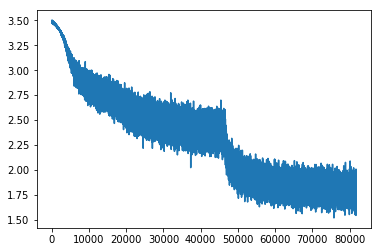

In [314]:
plt.plot(all_losses)

In [280]:
import pdb

In [ ]:
pdb.pm()

In [296]:
for i in range(10):
    print(generate(decoder, '****', 100, temperature=0.5), '\n')

****BALLE CREEK***************************************************************************************** 

****COORAMBERA PARK************************************************************************************* 

****POONG*********************************************************************************************** 

****WOLLEY********************************************************************************************** 

****MOORALLOR******************************************************************************************* 

****BALLE*********************************************************************************************** 

****NING************************************************************************************************ 

****NALANGARROWA**************************************************************************************** 

****WOOD************************************************************************************************ 

****BARRENTAY************************